# Luderick Instance Segmentation Using Pytorch Mask R-CNN (Training)

## Load the preprocessed DataFrames generated in the preprocessing Notebook

* Delete rows with no segmentation data so that training does not crash

In [1]:
# all imports
import pandas as pd
import numpy as np
import torch
import ast
import cv2
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm
from PIL import Image
import os
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random

plt.style.use('ggplot')

In [2]:
def load_luderick_df(file_path):
    """
    Loads a preprocessed luderick dataframe from a .csv and converts its 
    array column from string to a proper array. It also removes rows with no segmentation masks
    """
    loaded_df = pd.read_csv(file_path)
    # remove rows with no segmentation masks to train a mask r-cnn
    loaded_df = loaded_df[loaded_df['segmentation'] != '[]']
    loaded_df['labels'] = loaded_df['labels'].apply(lambda x: ast.literal_eval(x))
    loaded_df['bounding_boxes'] = loaded_df['bounding_boxes'].apply(lambda x: ast.literal_eval(x))
    loaded_df['area'] = loaded_df['area'].apply(lambda x: ast.literal_eval(x))
    loaded_df['segmentation'] = loaded_df['segmentation'].apply(lambda x: ast.literal_eval(x))
    
    return loaded_df

In [3]:
train_df = load_luderick_df('luderick_train_preprocessed.csv')
validation_df = load_luderick_df('luderick_validation_preprocessed.csv')

train_df

image_name       video_name  frame_number  \
0     04C1_Luderick_1.mov_5fps_000001.jpg  04C1_Luderick_1             1   
1     04C1_Luderick_1.mov_5fps_000002.jpg  04C1_Luderick_1             2   
2     04C1_Luderick_1.mov_5fps_000003.jpg  04C1_Luderick_1             3   
3     04C1_Luderick_1.mov_5fps_000004.jpg  04C1_Luderick_1             4   
4     04C1_Luderick_1.mov_5fps_000005.jpg  04C1_Luderick_1             5   
...                                   ...              ...           ...   
2667             C4_Luderick_9_014000.jpg    C4_Luderick_9            21   
2668             C4_Luderick_9_014200.jpg    C4_Luderick_9            22   
2669             C4_Luderick_9_014400.jpg    C4_Luderick_9            23   
2670             C4_Luderick_9_014600.jpg    C4_Luderick_9            24   
2671             C4_Luderick_9_014800.jpg    C4_Luderick_9            25   

      number_boxes labels            bounding_boxes      area  \
0                1    [1]  [[1778, 425, 1919, 610]]   [26085]   
1                1    [1]  [[1659, 406, 1919, 645]]   [62140]   
2                1    [1]  [[1578, 400, 1915, 620]]   [74140]   
3                1    [1]  [[1508, 398, 1812, 626]]   [69312]   
4                1    [1]  [[1465, 390, 1699, 626]]   [55224]   
...            ...    ...                       ...       ...   
2667             1    [1]    [[471, 127, 699, 360]]   [53124]   
2668             1    [1]     [[561, 79, 829, 313]]   [62712]   
2669             1    [1]     [[573, 33, 971, 261]]   [90744]   
2670             1    [1]     [[650, 3, 1126, 216]]  [101388]   
2671             1    [1]     [[797, 6, 1286, 184]]   [87042]   

                                           segmentation  
0     [[1778, 515, 1789, 498, 1806, 479, 1835, 457, ...  
1     [[1659, 509, 1675, 488, 1696, 465, 1720, 437, ...  
2     [[1578, 530, 1585, 512, 1594, 496, 1592, 477, ...  
3     [[1812, 624, 1795, 578, 1795, 542, 1797, 507, ...  
4     [[1691, 591, 1687, 544, 1688, 503, 1691, 473, ...  
...                                                 ...  
2667  [[471, 360, 491, 319, 492, 280, 487, 236, 489,...  
2668  [[578, 313, 592, 247, 618, 252, 656, 230, 679,...  
2669  [[578, 261, 594, 213, 601, 183, 594, 146, 581,...  
2670  [[650, 216, 676, 182, 673, 133, 674, 90, 673, ...  
2671  [[797, 184, 811, 150, 822, 123, 811, 70, 800, ...  

[2646 rows x 8 columns]

## Configuration

In [4]:
BATCH_SIZE = 2 # increase / decrease according to GPU memeory
#MAX_SIZE = 512 # resize the image for training and transforms
NUM_EPOCHS = 20 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# training images and XML files directory

IMAGES_DIR = "Fish_automated_identification_and_counting/luderick-seagrass"

# classes: 0 index is reserved for background
CLASSES = ['background', 'Luderick']
NUM_CLASSES = len(CLASSES)

# location to save model and plots
OUT_DIR = 'mask_rcnn_outputs'
!mkdir {OUT_DIR}

A subdirectory or file mask_rcnn_outputs already exists.


## Utility and helper functions

In [5]:
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
        
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
        
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf'), model_name='model'
    ):
        self.best_valid_loss = best_valid_loss
        self.model_name = model_name
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{OUT_DIR}/best_model_{self.model_name}_epoch_{epoch+1}.pth')

In [6]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number of objects
    and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [7]:
def save_model(epoch, model, optimizer, model_name='model'):
    """
    Function to save the trained model till current epoch, or whenver called
    """
    torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                }, f'{OUT_DIR}/last_model_{model_name}.pth')


In [8]:
def save_loss_plot(output_dir, train_loss, val_loss, mean_train_loss, mean_valid_loss, epoch_num, model_name):
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()
    figure_3, mean_ax = plt.subplots()
    
    train_ax.plot(train_loss, color='tab:blue')
    train_ax.set_xlabel('iterations')
    train_ax.set_ylabel('train loss')
    valid_ax.plot(val_loss, color='tab:red')
    valid_ax.set_xlabel('iterations')
    valid_ax.set_ylabel('validation loss')
    figure_1.savefig(f"{output_dir}/{model_name}_train_loss.png")
    figure_2.savefig(f"{output_dir}/{model_name}_valid_loss.png")
    
    mean_ax.plot(np.arange(epoch_num)+1, mean_train_loss, label='Training loss')
    mean_ax.plot(np.arange(epoch_num)+1, mean_valid_loss, label='Validation Loss')
    mean_ax.set_xticks(np.arange(1, NUM_EPOCHS+1, step=1))
    mean_ax.set_ylabel('Loss')
    mean_ax.set_xlabel('Epochs')
    mean_ax.set_title('Loss Curves')
    mean_ax.legend()
    figure_3.savefig(f"{output_dir}/{model_name}_epoch_loss.png")
    
    print('SAVING PLOTS COMPLETE...')
    
    plt.close('all')

In [9]:
def convert_dataset_image(image):
    """
    Convert an image from the dataset format and return it as PIL Image
    """
    image = np.array(image.cpu()).transpose(1, 2, 0)
    return Image.fromarray((image*255).astype(np.uint8))

In [10]:
def view_image_aray(image_array):
    """
    Display the image array
    """
    image = Image.fromarray((image_array).astype(np.uint8))  # Pil Image needs the image to be in int format
    display(image)

In [11]:
def view_image_boxes(image, boxes):
    """
    View an image with bounding boxes
    """
    image = np.asarray(image)
    for i, box in enumerate(boxes):
        cv2.rectangle(image,
                     (int(box[0]), int(box[1])), (int(box[2]), int(box[3])),
                     (255, 0, 0), 2)
        
    view_image_aray(image)

## Create segmentation masks

Mask R-CNN on pytorch reads segmentation masks as binary masks. To get them, the following steps will be followed:
* Convert the segmentation points array into a grayscale segmentation image with a different color for each instance
* Iterate over the number of instances and create a binary boolean mask for each using the segmentation image

In [12]:
def draw_image_segementation(image, segmentations):
    """
    Returns the segmentation masks from an image in a gray scale imageusing the segmentaiton contourn points
    Each segmentation has a different grayscale color
    """
    height, width, channels = np.array(image).shape
    
    # create a black image with the same size as the input
    segmentation_image = np.zeros((height, width, 1))
    
    for i, segmentation in enumerate(segmentations):
        x_coords = []
        y_coords = []
        # iterate over the coodinates of the segmentation
        for j, coord in enumerate(segmentation):
            # coordinates at even positions represent an x position
            # coordinates at odd positions represent an y position
            if j%2 == 0:
                x_coords.append(coord) 
            else:
                y_coords.append(coord)
        # create an array of points (x, y)
        segm_points = [list(coord) for coord in zip(x_coords, y_coords)]

        # draw the contours of the segmentation mask and fill with color
        # each segmentation mask from the image has a different color
        cv2.drawContours(segmentation_image, 
                         np.array([segm_points], dtype='int32'),
                         -1,
                         i+1, # paint each segmentation in a different color, starting from 1 (0 is black)
                         thickness=cv2.FILLED)
        
    # convert the shape from (height, width, 1) to (height, width)
    segmentation_image = np.squeeze(segmentation_image)
    
    return segmentation_image   

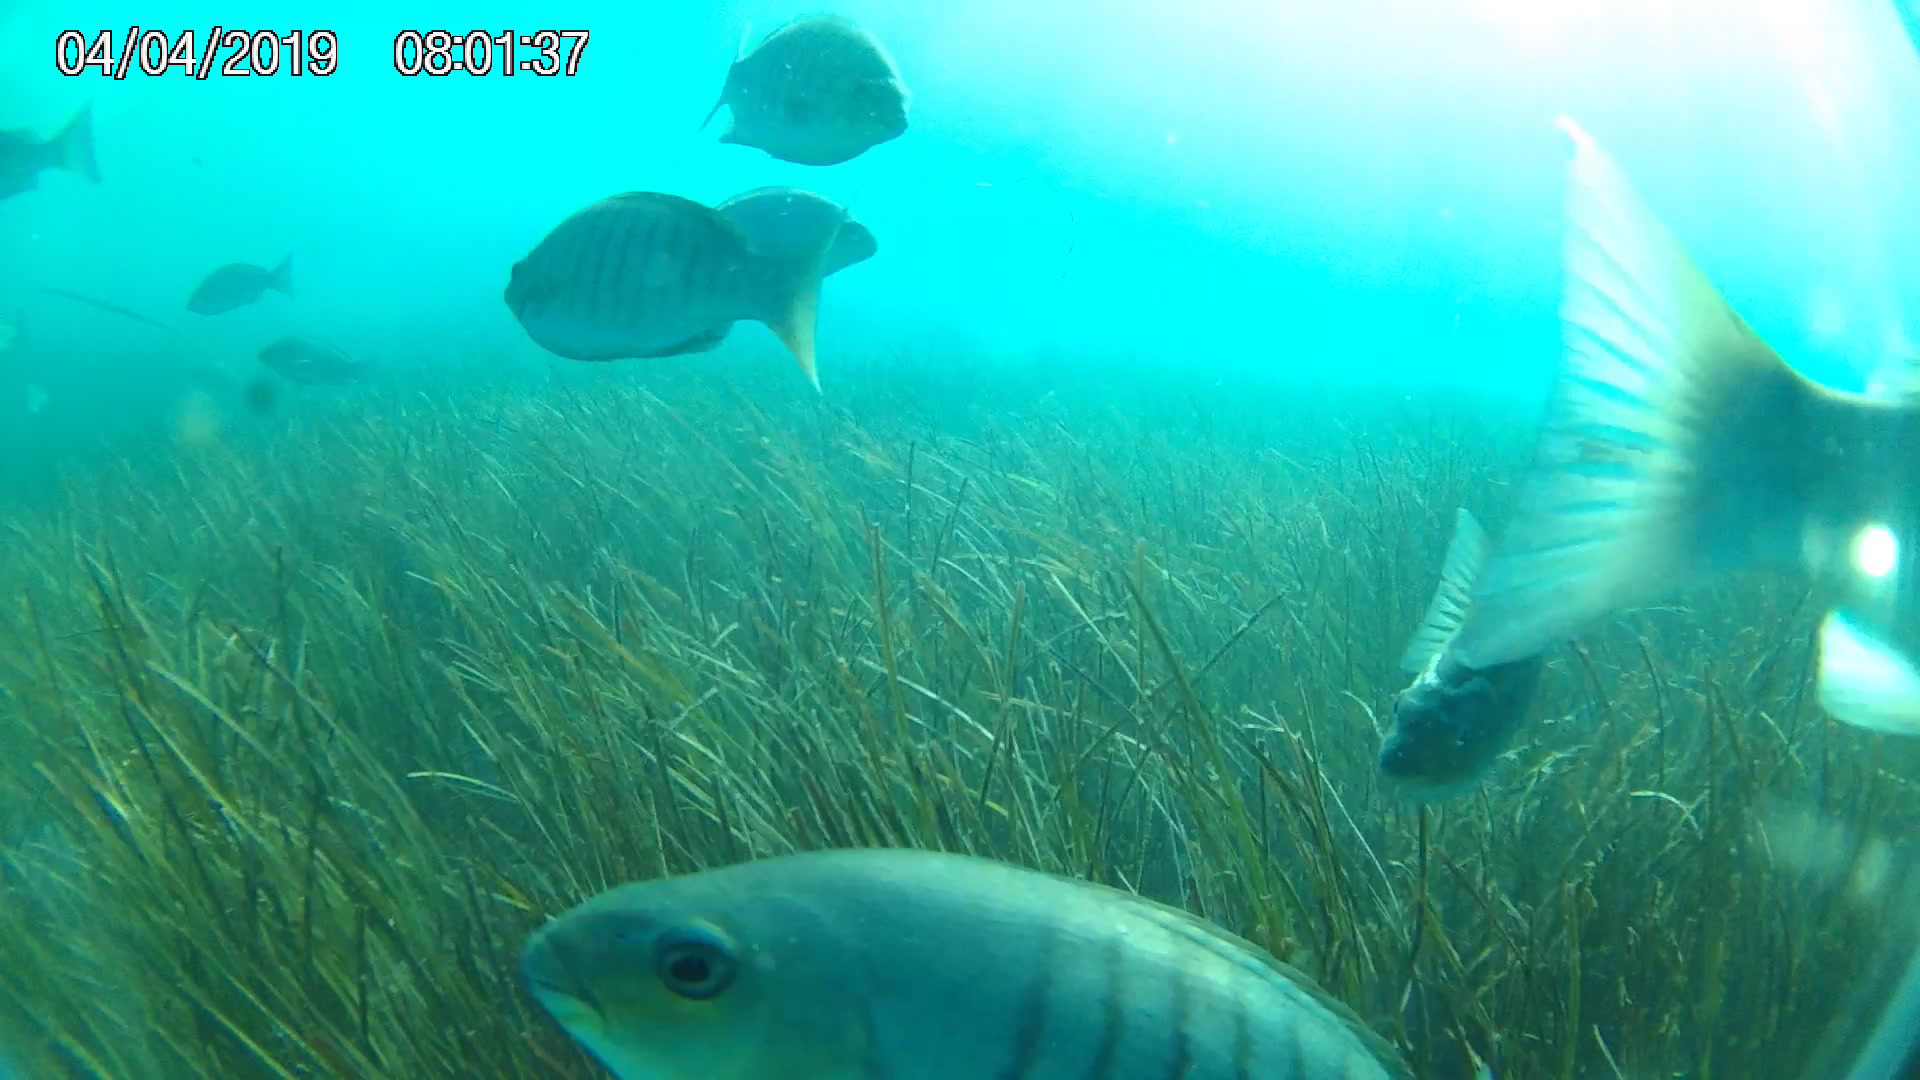

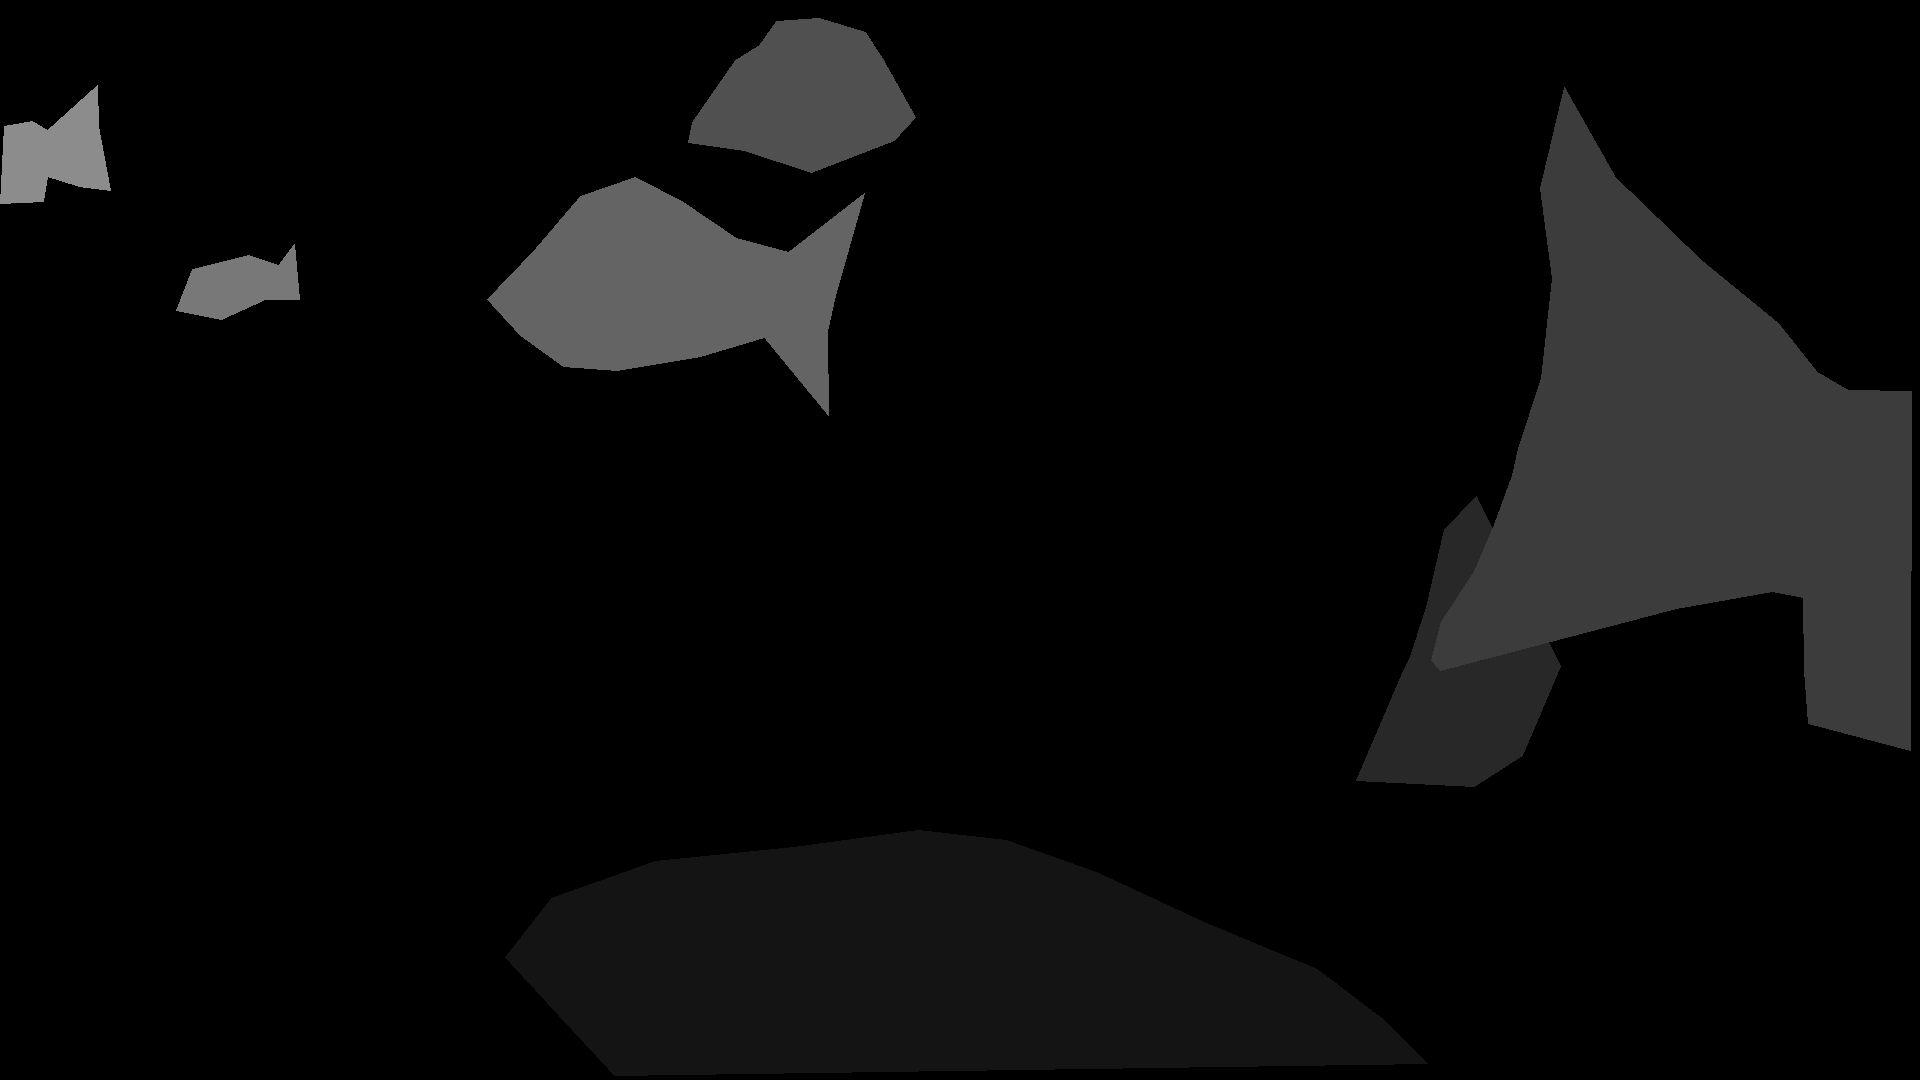

In [13]:
image_name = train_df.iloc[90]['image_name']
image_path = os.path.join(IMAGES_DIR, image_name)
image = Image.open(image_path)

image_segmentation = draw_image_segementation(image, train_df.iloc[90]['segmentation'])

#multiply pixel values by 20 to have better visualization
display(image)
view_image_aray(image_segmentation*20)

In [14]:
def get_binary_masks(segm_mask):
    """
    Converts a gray scale segmentation mask image into an array of binary boolean matrices
    """
    # create an array with all the different gray scale colors in the segmentation image
    object_ids = np.unique(segm_mask)
    # remove the background color (0)
    object_ids = object_ids[1:]
    
    # create a binary mask matrix for each different object with True where the pixels of each objects are
    binary_masks = [segm_mask == i for i in object_ids]
    
    return np.array(binary_masks)

In [15]:
masks = get_binary_masks(image_segmentation)
masks.shape, type(masks[0][0][0])

((7, 1080, 1920), numpy.bool_)

## Get bounding boxes from segmentation masks

Segmentation masks can give bounding box information based on the minimum and max left, right, top and bottom positions where the binary mask has a positive. 

This way, an image and segmentation can be transformed using data augmentation and get the new bounding boxes easily.

In [16]:
def masks_to_boxes(binary_masks):
    """
    Return the bounding box coordinates from a list of binary masks
    """
    num_objects = len(binary_masks)
    boxes = []
    for i in range(num_objects):
        # np.where returns the positions where there are True values in the matrix
        # in the form of a list of y coordinates and another of x coordinates 
        pos = np.where(binary_masks[i])
        # get the minimum and maximum x and y positions
        x_min = np.min(pos[1])
        x_max = np.max(pos[1])
        y_min = np.min(pos[0])
        y_max = np.max(pos[0])
        
        # save the box in the list
        boxes.append([x_min, y_min, x_max, y_max])
    
    return boxes

In [17]:
boxes = masks_to_boxes(masks)
boxes

[[505, 830, 1427, 1075],
 [1356, 496, 1560, 786],
 [1431, 87, 1911, 750],
 [688, 18, 915, 172],
 [487, 177, 864, 415],
 [176, 244, 299, 319],
 [0, 85, 110, 203]]

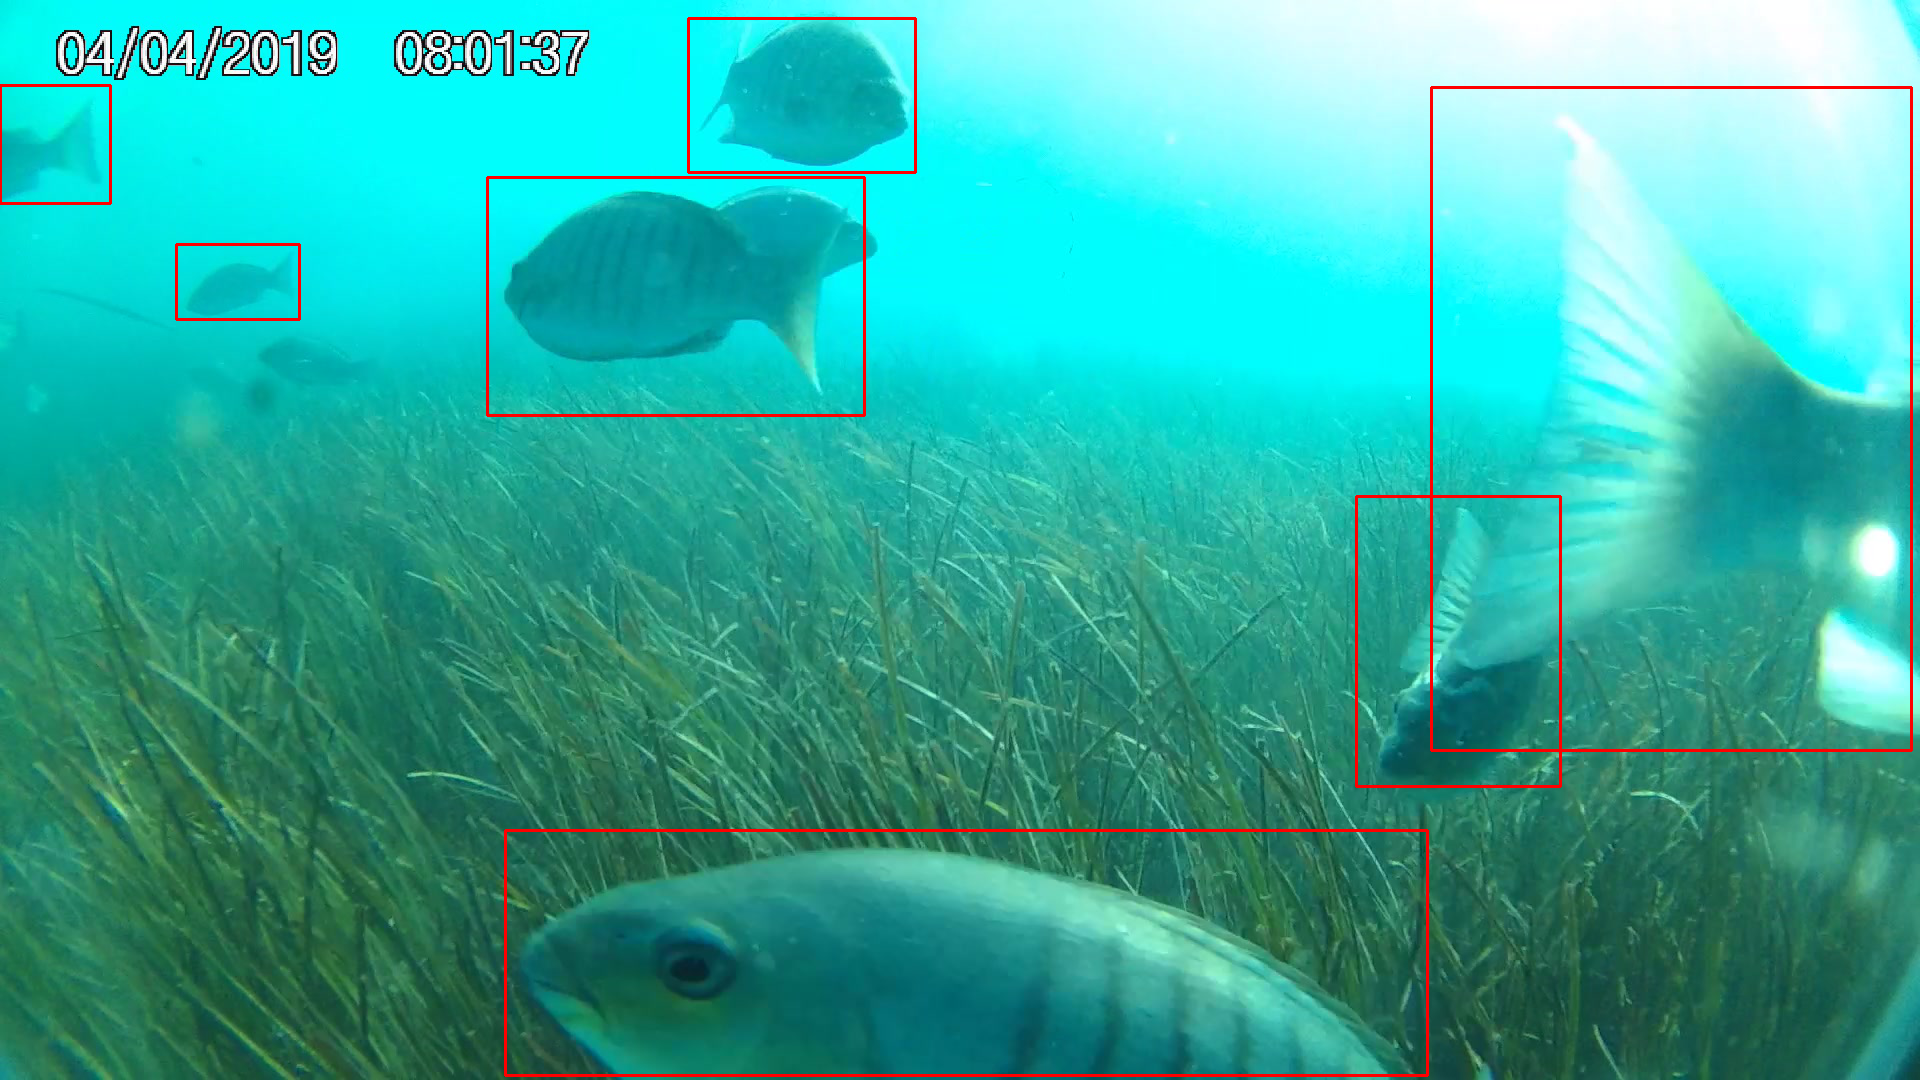

In [18]:
# check that the bounding boxes generated are correct
view_image_boxes(image, boxes)

## Transform functions

Taken from the official pytorch tutorial on mask R-CNN
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Use pytorch utility scripts for detection from their github:
https://github.com/pytorch/vision/tree/main/references/detection

The scripts are downloaded and saved in the same folder as this notebook

In [19]:
import torchvision.transforms as transforms

def get_transform(train):
    transforms_list = []
    transforms_list.append(transforms.ToTensor())
    if train:
        transforms_list.append(transforms.RandomHorizontalFlip(0.5))
        transforms_list.append(transforms.RandomVerticalFlip(0.5))
    return transforms.Compose(transforms_list)

## The Dataset Class

In [20]:
class LuderickDataset(torch.utils.data.Dataset):
    def __init__(self, luderick_df, images_dir, classes, transforms=None):
        self.luderick_df = luderick_df
        self.images_dir = images_dir
        self.classes = classes
        self.transforms = transforms

    def __getitem__(self, idx):
        # load images and masks
        row = self.luderick_df.iloc[idx]
        image_path = os.path.join(self.images_dir, row['image_name'])
        
        #read the image
        image = Image.open(image_path).convert("RGB")

        num_objects = row['number_boxes']
        segmentations = row['segmentation']
        labels = row['labels']
        area = row['area']
        # get the segmentation image
        segmentation_image = draw_image_segementation(image, segmentations)
        
        # transform the image and the segmentation_image with the same random transforms
        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        random.seed(seed) # apply this seed to image tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        # apply the image transforms
        if self.transforms is not None:
            image = self.transforms(image)
            
        random.seed(seed) # apply this seed to image tranfsorms
        torch.manual_seed(seed) # needed for torchvision 0.7
        if self.transforms is not None:
            segmentation_image = self.transforms(segmentation_image)
    
        # convert the segmentation image back to an array and desnormalize it (multiply by 255)
        segmentation_image = np.array(segmentation_image*255)[0]
        # convert the segmentation image into segmentation mask array
        masks = get_binary_masks(segmentation_image)
        # get the boxes out of the binary masks
        boxes = masks_to_boxes(masks)

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        
        image_id = torch.tensor([idx])
        area = torch.as_tensor(area, dtype=torch.int64)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objects,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["masks"] = masks
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        return image, target

    def __len__(self):
        return len(self.luderick_df)

In [21]:
# create the dataset instances
train_dataset = LuderickDataset(train_df, IMAGES_DIR, CLASSES, transforms=get_transform(train=True))
valid_dataset = LuderickDataset(validation_df, IMAGES_DIR, CLASSES, transforms=get_transform(train=False))

(1920, 1080)


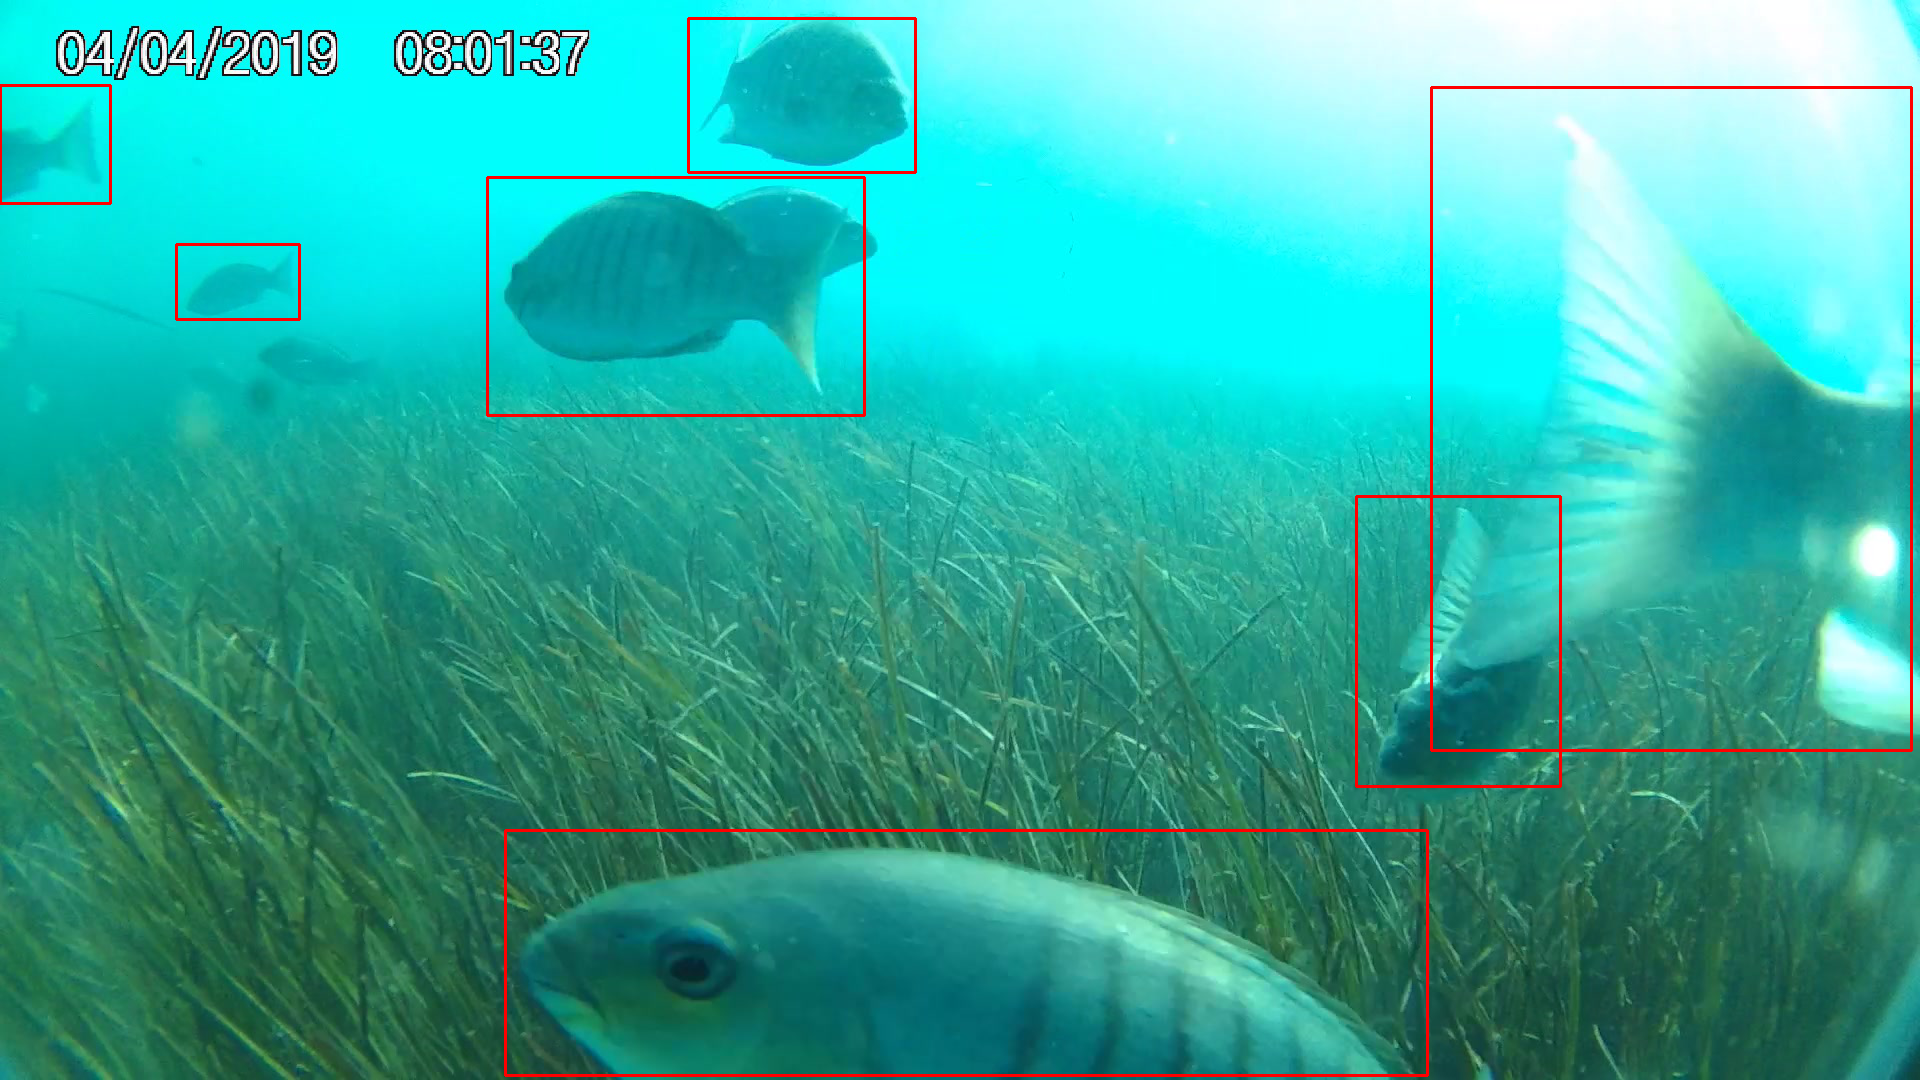

In [22]:
# check one example
image, target = train_dataset[90]
# check that the resizing was correct
image = convert_dataset_image(image)
print(image.size)

# visualize image and the bounding boxes after transformations. 
# If boxes are correct, segmentation masks should be as well
view_image_boxes(image, target['boxes'])

## Create the Data Loaders

In [23]:
train_loader = DataLoader(train_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=True, # shuffle the dataset to avoid overfitting on long sequences
                         num_workers=0,
                         collate_fn=collate_fn)

valid_loader = DataLoader(valid_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=0,
                         collate_fn=collate_fn)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 2646
Number of validation samples: 824



Batch size: 2
(1920, 1080)


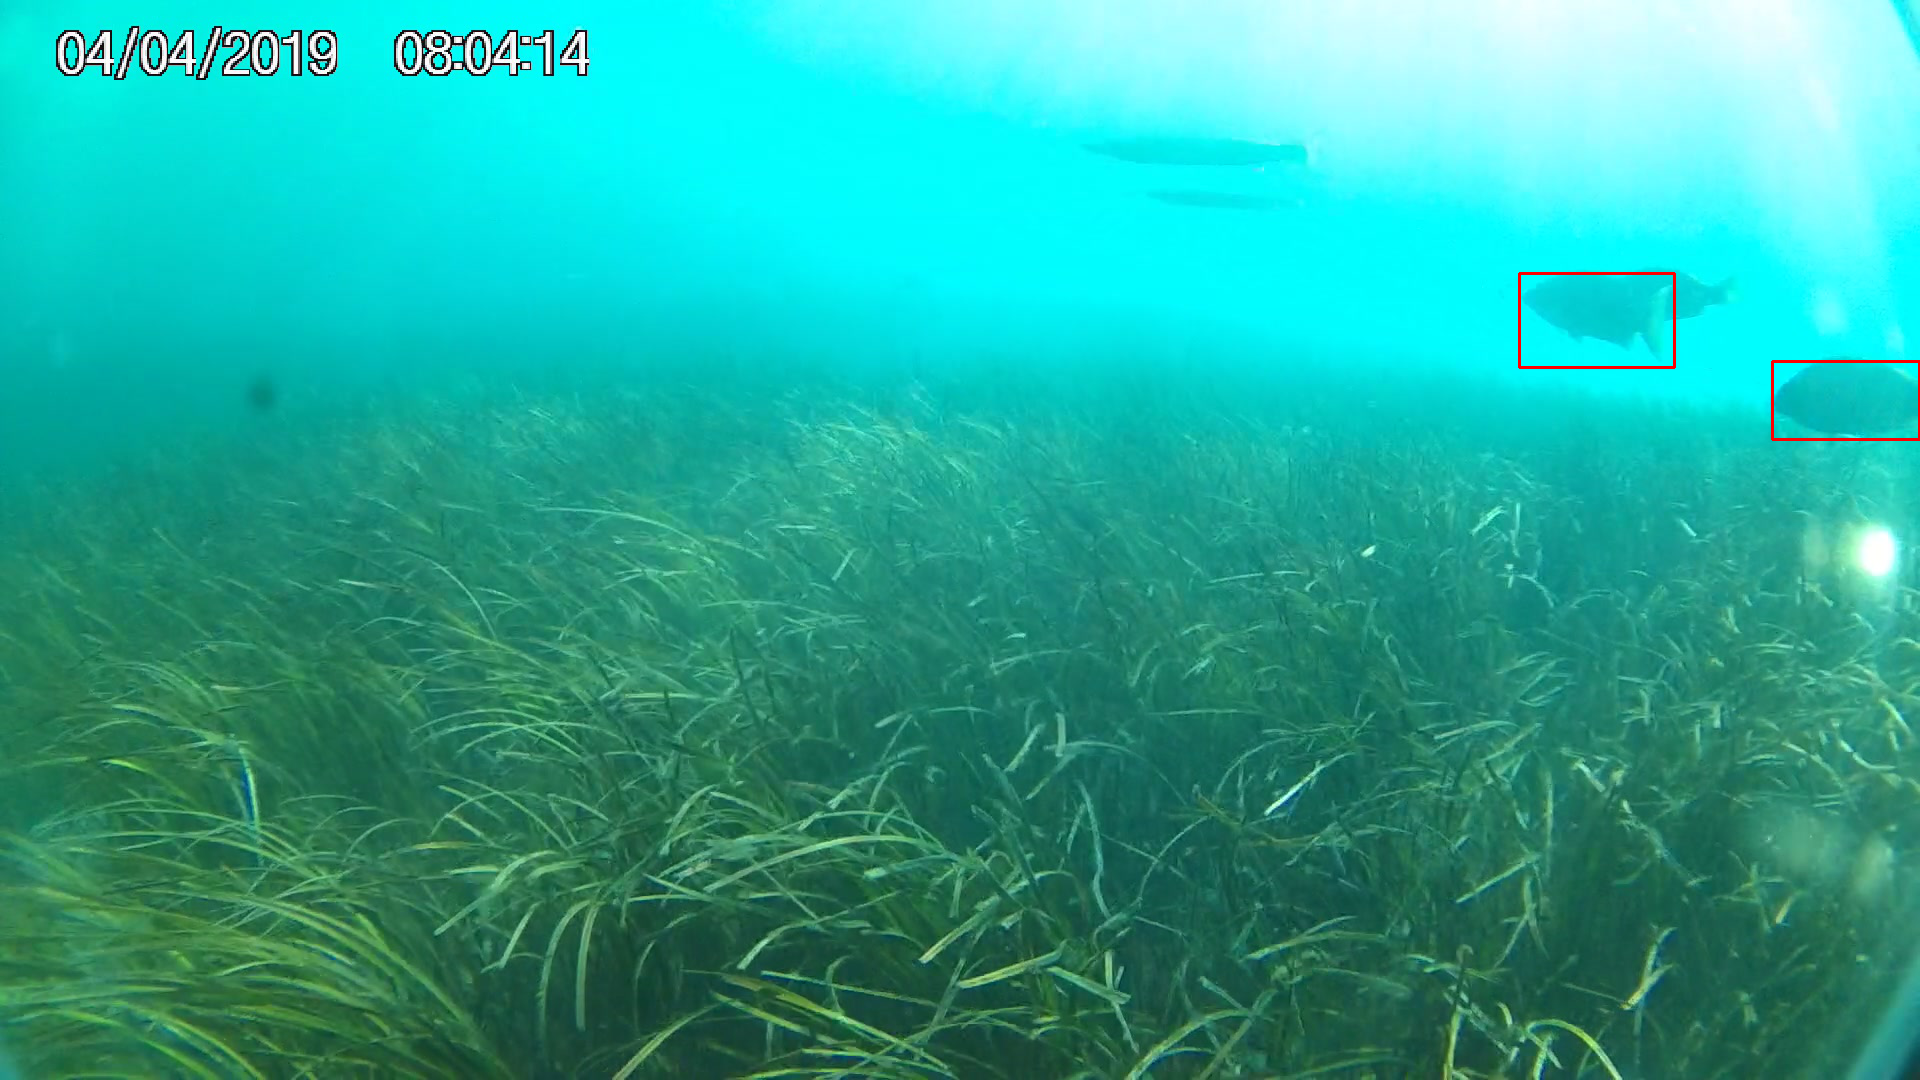

In [24]:
# get one batch of images and targets
image, target = next(iter(train_loader))
# check the batch size
print(f'Batch size: {len(image)}')
# display the first image
image = convert_dataset_image(image[0])
print(image.size)
view_image_boxes(image, target[0]['boxes'])

## Load the Mask R-CNN model

In [25]:
def create_model(num_classes):
    
    # load mask r-cnn model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # get the number of input features
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # define a new head for the detector with the required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

## The training function

In [26]:
# function for running training iterations
def train(train_data_loader, model, device):
    print('Training')
    global train_itr
    global train_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(train_data_loader, total=len(train_data_loader))
    
    for i, data in enumerate(prog_bar):
        # reset the gradient accummulation from the previous batch
        optimizer.zero_grad()
        images, targets = data
        
        # use the device from the configuration (gpu if afailable)
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        # the model returns the losses in training mode, including the 
        # classification loss, rpn and final bounding box regression loss
        # and rpn objectness loss
        loss_dict = model(images, targets)
        
        # add all the losses to get the total loss
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        train_loss_list.append(loss_value)
        
        train_loss_hist.send(loss_value)
        
        # backpropagate the total loss
        losses.backward()
        # update the parameters according to their gradients
        optimizer.step()
        
        train_itr += 1
        
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return train_loss_list

## The validation function

In [27]:
# function for running validation iterations
def validate(valid_data_loader, model, device):
    print("Validating")
    global val_itr
    global val_loss_list
    
    # initialize tqdm progress bar
    prog_bar = tqdm(valid_data_loader, total=len(valid_data_loader))
    
    for i, data in enumerate(prog_bar):
        images, targets = data
        
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        with torch.no_grad():
            loss_dict = model(images, targets)
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        val_loss_list.append(loss_value)
        
        val_loss_hist.send(loss_value)
        
        val_itr += 1
        
        # update the loss value beside the progress bar for each iteration
        prog_bar.set_description(desc=f"Loss: {loss_value:.4f}")
    return val_loss_list

## Main Code

In [28]:
# initialize the model and move to the computation device
model = create_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
# get the mdel parameters
params = [p for p in model.parameters() if p.requires_grad]
# define the optimizer
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=0.0005)

# initialize the Averager class
train_loss_hist = Averager()
val_loss_hist = Averager()
train_itr = 1
val_itr = 1
# train and validation loss lists to store loss values of all...
# ... iterations till end and prot graphs for all iterations
train_loss_list = []
val_loss_list = []

# mean losses for train and validation at every epoch
epoch_train_losses = []
epoch_validation_losses = []

# name to save the trained model with
MODEL_NAME = "MODEL_MASK_1920_aug_1"

# initialize SaveBestModel class
save_best_model = SaveBestModel(model_name=MODEL_NAME)

# start the training epochs
for epoch in range(NUM_EPOCHS):
    print(f"\nEPOCH {epoch+1} of {NUM_EPOCHS}")

    # reset the training and valitation loss histories for the current epoch
    train_loss_hist.reset()
    val_loss_hist.reset()

    # create two subplots, one for each, training and validation
    figure_1, train_ax = plt.subplots()
    figure_2, valid_ax = plt.subplots()

    # start timer and carry out training and validation
    start = time.time()
    train_loss = train(train_loader, model, DEVICE)
    val_loss = validate(valid_loader, model, DEVICE)
    print(f"Epoch #{epoch+1} train_loss: {train_loss_hist.value:.3f}")
    print(f"Epoch #{epoch+1} validation_loss: {val_loss_hist.value:.3f}")
    end = time.time()
    print(f"Took {(end - start):.3f} seconds for epoch {epoch+1}")

    # save the mean train and validation losses of this epoch
    epoch_train_losses.append(train_loss_hist.value)
    epoch_validation_losses.append(val_loss_hist.value)
    
    # save the best model until now if we have the minimum val loss this epoch
    save_best_model(val_loss_hist.value, epoch, model, optimizer)
    
    #save the current epoch model
    save_model(epoch, model, optimizer, model_name=MODEL_NAME)
    
    #save the loss plot
    save_loss_plot(OUT_DIR, train_loss, val_loss, epoch_train_losses, epoch_validation_losses, epoch+1, MODEL_NAME)


EPOCH 1 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #1 train_loss: 0.479
Epoch #1 validation_loss: 0.351
Took 811.604 seconds for epoch 1

Best validation loss: 0.35075053740835305

Saving best model for epoch: 1

SAVING PLOTS COMPLETE...

EPOCH 2 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #2 train_loss: 0.421
Epoch #2 validation_loss: 0.341
Took 819.186 seconds for epoch 2

Best validation loss: 0.34144916817618226

Saving best model for epoch: 2

SAVING PLOTS COMPLETE...

EPOCH 3 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #3 train_loss: 0.406
Epoch #3 validation_loss: 0.331
Took 812.448 seconds for epoch 3

Best validation loss: 0.33127276778438136

Saving best model for epoch: 3

SAVING PLOTS COMPLETE...

EPOCH 4 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #4 train_loss: 0.396
Epoch #4 validation_loss: 0.333
Took 801.383 seconds for epoch 4
SAVING PLOTS COMPLETE...

EPOCH 5 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #5 train_loss: 0.389
Epoch #5 validation_loss: 0.326
Took 801.892 seconds for epoch 5

Best validation loss: 0.3264664942489087

Saving best model for epoch: 5

SAVING PLOTS COMPLETE...

EPOCH 6 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #6 train_loss: 0.381
Epoch #6 validation_loss: 0.328
Took 800.455 seconds for epoch 6
SAVING PLOTS COMPLETE...

EPOCH 7 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #7 train_loss: 0.373
Epoch #7 validation_loss: 0.326
Took 800.070 seconds for epoch 7

Best validation loss: 0.3263087423825727

Saving best model for epoch: 7

SAVING PLOTS COMPLETE...

EPOCH 8 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #8 train_loss: 0.368
Epoch #8 validation_loss: 0.328
Took 802.033 seconds for epoch 8
SAVING PLOTS COMPLETE...

EPOCH 9 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #9 train_loss: 0.362
Epoch #9 validation_loss: 0.326
Took 799.611 seconds for epoch 9

Best validation loss: 0.3256295068930943

Saving best model for epoch: 9

SAVING PLOTS COMPLETE...

EPOCH 10 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #10 train_loss: 0.357
Epoch #10 validation_loss: 0.333
Took 806.520 seconds for epoch 10
SAVING PLOTS COMPLETE...

EPOCH 11 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #11 train_loss: 0.353
Epoch #11 validation_loss: 0.327
Took 803.619 seconds for epoch 11
SAVING PLOTS COMPLETE...

EPOCH 12 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #12 train_loss: 0.349
Epoch #12 validation_loss: 0.330
Took 807.690 seconds for epoch 12
SAVING PLOTS COMPLETE...

EPOCH 13 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #13 train_loss: 0.344
Epoch #13 validation_loss: 0.332
Took 807.950 seconds for epoch 13
SAVING PLOTS COMPLETE...

EPOCH 14 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #14 train_loss: 0.339
Epoch #14 validation_loss: 0.335
Took 815.375 seconds for epoch 14
SAVING PLOTS COMPLETE...

EPOCH 15 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #15 train_loss: 0.335
Epoch #15 validation_loss: 0.353
Took 810.657 seconds for epoch 15
SAVING PLOTS COMPLETE...

EPOCH 16 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #16 train_loss: 0.332
Epoch #16 validation_loss: 0.336
Took 817.133 seconds for epoch 16
SAVING PLOTS COMPLETE...

EPOCH 17 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #17 train_loss: 0.326
Epoch #17 validation_loss: 0.339
Took 817.547 seconds for epoch 17
SAVING PLOTS COMPLETE...

EPOCH 18 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #18 train_loss: 0.325
Epoch #18 validation_loss: 0.338
Took 808.224 seconds for epoch 18
SAVING PLOTS COMPLETE...

EPOCH 19 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #19 train_loss: 0.320
Epoch #19 validation_loss: 0.352
Took 810.281 seconds for epoch 19
SAVING PLOTS COMPLETE...

EPOCH 20 of 20
Training


  0%|          | 0/1323 [00:00<?, ?it/s]

Validating


  0%|          | 0/412 [00:00<?, ?it/s]

Epoch #20 train_loss: 0.317
Epoch #20 validation_loss: 0.341
Took 807.867 seconds for epoch 20
SAVING PLOTS COMPLETE...


In [29]:
print(f'Best validation loss = {save_best_model.best_valid_loss}')

Best validation loss = 0.3256295068930943


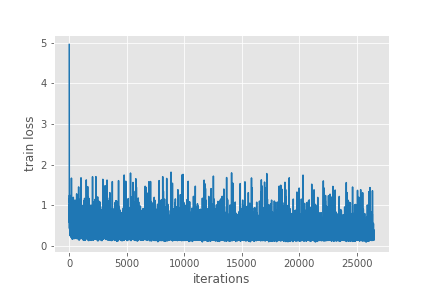

In [30]:
Image.open(f'{OUT_DIR}/{MODEL_NAME}_train_loss.png')

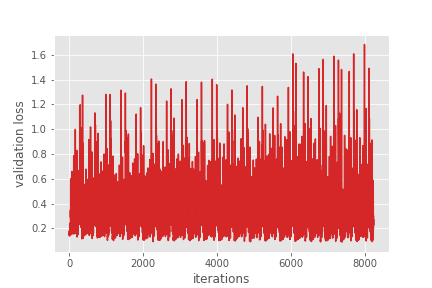

In [32]:
Image.open(f'{OUT_DIR}/{MODEL_NAME}_valid_loss.png')

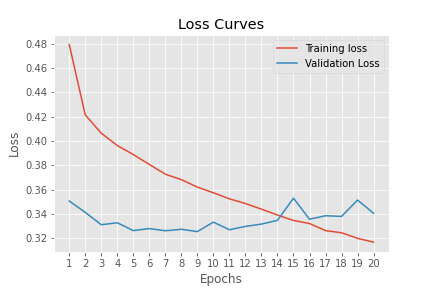

In [33]:
Image.open(f'{OUT_DIR}/{MODEL_NAME}_epoch_loss.png')